In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import scienceplots

import time
import math
import os
import random
from functools import partial
from decimal import Decimal
import numpy as np
import scipy.io as sio
import pysindy as ps
from tqdm import trange

from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.dnsga2 import DNSGA2
from pymoo.core.problem import ElementwiseProblem
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.core.duplicate import ElementwiseDuplicateElimination
from pymoo.termination.default import DefaultMultiObjectiveTermination
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.core.problem import StarmapParallelization
from multiprocessing.pool import ThreadPool

from utils import *
from skimage.restoration import estimate_sigma
import bm3d
# from okridge.solvel0 import *
from solvel0 import solvel0, MIOSR
from best_subset import backward_refinement, brute_force_all_subsets
from UBIC import *
from kneed import KneeLocator
from bayesian_model_evidence import log_evidence

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.preprocessing import StandardScaler
from sklearn import covariance
from sklearn.metrics import mean_absolute_percentage_error

sage is not installed to the environment.
mrmr is not installed in the env you are using. This may cause an error in future if you try to use the (missing) lib.
L0BnB is not installed.


In [2]:
n_poly = 6
n_derivatives = 6
n_modules = 8

In [3]:
data_path = "../PDE-Discovery-EC/Datasets/"
data = sio.loadmat(os.path.join(data_path, "burgers.mat"))
u_clean = (data['usol']).real; u = u_clean.copy()
x = (data['x'][0]).real
t = (data['t'][:,0]).real
dt = t[1]-t[0]; dx = x[2]-x[1]

### Add noise

In [4]:
np.random.seed(0)
noise_type = "gaussian"
noise_lv = float(50)
print("Noise level:", noise_lv)
noise = 0.01*np.abs(noise_lv)*(u.std())*np.random.randn(u.shape[0],u.shape[1])
u = u + noise

Noise level: 50.0


### Denoise

In [5]:
# bm3d_file = f"./Denoised_data/burgers_{noise_type}{int(noise_lv)}_bm3d.npy"
# load_denoised_data = True
# if load_denoised_data:
#     print("Loading denoised data...")
#     u = np.load(bm3d_file)
# else:
#     kernel = RBF(length_scale=1, length_scale_bounds=(1e-2, 1e3)) + \
#                     WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e10))
    
#     xx = colvec(x)
#     u_mean = np.copy(u)
#     u_std = np.ones(u.shape)
#     for i in trange(len(t)):    
#         gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.0, 
#                                        n_restarts_optimizer=10 # 20
#                                       )
    
#         gpr.fit(xx, u_mean[:, i])
#         um, ustd = gpr.predict(xx, return_std=True)
#         u_mean[:, i] = um
#         u_std[:, i] = ustd
    
#     est_sigma = u_std.mean() # max also works well
#     # est_sigma = (est_sigma+estimate_sigma(u))/2
#     u = bm3d.bm3d(u, sigma_psd=est_sigma, 
#                   stage_arg=bm3d.BM3DStages.ALL_STAGES, 
#                   blockmatches=(False, False))
    
#     ### to save ###
#     # np.save(bm3d_file, u)

np.random.seed(0)
fake_noise = np.random.normal(loc=0.0, scale=estimate_sigma(u), size=u.shape)
sigmas = estimate_sigma(u+fake_noise)*np.arange(0.1, 2., 0.1)
est_sigma = sigmas[np.argmin([((u-bm3d.bm3d(u+fake_noise, sigma_psd=sigma, stage_arg=bm3d.BM3DStages.ALL_STAGES, blockmatches=(False, False)))**2).mean() \
                              for sigma in sigmas])]
u = bm3d.bm3d(u, sigma_psd=est_sigma, 
                  stage_arg=bm3d.BM3DStages.ALL_STAGES, 
                  blockmatches=(False, False))

In [6]:
xt = np.array([x.reshape(-1, 1), t.reshape(1, -1)], dtype=object)
X, T = np.meshgrid(x, t)
XT = np.asarray([X, T]).T

In [7]:
function_library = ps.PolynomialLibrary(degree=n_poly, include_bias=False)

weak_lib = ps.WeakPDELibrary(
    function_library=function_library,
    derivative_order=n_derivatives,
    spatiotemporal_grid=XT,
    include_bias=True,
    diff_kwargs={"is_uniform":True},
    K=10000
)

X_pre = np.array(weak_lib.fit_transform(np.expand_dims(u, -1)))
y_pre = weak_lib.convert_u_dot_integral(np.expand_dims(u, -1))
feature_names = np.array(weak_lib.get_feature_names())
R_path = "./Cache/"
np.save(os.path.join(R_path, f"X_pre_burgers_noise{int(noise_lv)}.npy"), X_pre)
np.save(os.path.join(R_path, f"y_pre_burgers_noise{int(noise_lv)}.npy"), y_pre)
np.save(os.path.join(R_path, f"feature_names_burgers.npy"), feature_names)

In [8]:
base_poly = np.array([[p, 0] for p in range(1, n_poly+1)])
base_derivative = np.array([[0, d] for d in range(1, n_derivatives+1)])
modules = [(0, 0)] if weak_lib.include_bias else []
modules += [(p, 0) for p in range(1, n_poly+1)] + \
            [(0, d) for d in range(1, n_derivatives+1)] + \
            [tuple(p+d) for d in base_derivative for p in base_poly]
assert len(modules) == len(weak_lib.get_feature_names())
base_features = dict(zip(modules, X_pre.T))
u_t = y_pre.copy()

### Straightforward best-subset selection

In [9]:
# over 30 minutes for n_poly = 6 and n_derivatives = 6
# miosr_subsets = solvel0(X_pre, y_pre, miosr=True)

### Genetic algorithm with NSGA-II

In [10]:
class PdeDiscoveryProblem(ElementwiseProblem):
    def __init__(self, n_poly, n_derivatives, n_modules, 
                 base_features, u_t, order_complexity=False, **kwargs):
        super().__init__(n_var=1, n_obj=2, n_ieq_constr=0, **kwargs)
        self.n_poly = n_poly
        self.n_derivatives = n_derivatives
        self.n_modules = n_modules
        self.base_features = base_features
        self.u_t = u_t
        self.sample_size = np.prod(self.u_t.shape)
        self.order_complexity = order_complexity

    def _evaluate(self, X, out, *args, **kwargs):
        genome = X[0]
        coeff, mse = self.compute_genome_coefficient(genome)
        mse = mse/self.sample_size
        complexity_penalty = len(genome)
        if self.order_complexity:
            complexity_penalty += sum(sum(_) for _ in genome)
        out["F"] = [mse, complexity_penalty]

    def numericalize_genome(self, genome):
        return np.stack([self.base_features[tuple(module)] 
                         for module in genome], axis=-1)

    def compute_genome_coefficient(self, genome):
        features = self.numericalize_genome(genome)
        features = features.reshape(-1, features.shape[-1])
        coeff, error, _, _ = np.linalg.lstsq(features, self.u_t, rcond=None)
        return coeff, error[0]
    
    def generate_module(self):
        return (random.randint(0, self.n_poly), random.randint(0, self.n_derivatives))
    
    def set_epsilon(self, epsilon):
        self.epsilon = epsilon

    def set_order_complexity(self, order_complexity):
        self.order_complexity = order_complexity
    
class PopulationSampling(Sampling):
    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, 1), None, dtype=object)
        X_set = set()
        i = 0
        while i < n_samples:
            n_modules = random.randint(1, problem.n_modules)
            genome = frozenset(problem.generate_module() for _ in range(n_modules))
            if len(genome) > 0 and genome not in X_set:
                X_set.add(genome)
                X[i, 0] = genome
                i += 1
        return X
    
class DuplicateElimination(ElementwiseDuplicateElimination):
    def is_equal(self, g1, g2):
        return g1.X[0] == g2.X[0]

In [11]:
class GenomeCrossover(Crossover):
    def __init__(self):
        # define the crossover: number of parents and number of offsprings
        super().__init__(2, 2)

    def _do(self, problem, X, **kwargs):
        # The input of has the following shape (n_parents, n_matings, n_var)
        _, n_matings, n_var = X.shape

        # The output owith the shape (n_offsprings, n_matings, n_var)
        # Because there the number of parents and offsprings are equal it keeps the shape of X
        Y = np.full_like(X, None, dtype=object)
        
        # for each mating provided
        for k in range(n_matings):
            # get the first and the second parent          
            Y[0, k, 0], Y[1, k, 0] = self.crossover_permutation(X[0, k, 0], X[1, k, 0])
            
        return Y
    
    def crossover_permutation(self, genome1, genome2):
        collection = list(genome1) + list(genome2)
        random.shuffle(collection)
        return frozenset(collection[:len(genome1)]), frozenset(collection[len(genome1):])
    
class GenomeMutation(Mutation):
    def __init__(self, add_rate=0.4, del_rate=0.5, order_rate=0.4):
        super().__init__()
        self.add_rate = add_rate
        self.del_rate = del_rate
        self.order_rate = order_rate

    def _do(self, problem, X, **kwargs):
        for i in range(len(X)):
            if random.random() < self.add_rate:
                X[i, 0] = self.add_mutate(problem, X[i, 0])
            if random.random() < self.del_rate:
                X[i, 0] = self.del_mutate(problem, X[i, 0])
            if random.random() < self.order_rate:
                X[i, 0] = self.module_mutate(problem, X[i, 0])
        return X
    
    def add_mutate(self, problem, genome, max_iter=3):
        for _ in range(max_iter):
            new_module = problem.generate_module()
            if new_module not in genome:
                return genome.union(frozenset({new_module}))
        return genome
    
    def del_mutate(self, problem, genome, max_iter=3):
        genome = list(genome)
        lg = len(genome)
        if lg > 0:
            if lg == 1:
                for _ in range(max_iter):
                    new_module = problem.generate_module()
                    if new_module != genome[0]:
                        return frozenset({new_module})
            else:
                genome.pop(random.randint(0, lg-1))
        return frozenset(genome)
    
    def module_mutate(self, problem, genome):
        if len(genome) == 0:
            return genome
        genome = set(genome)
        genome.remove(random.choice(list(genome)))
        for _ in range(3):
            new_module = problem.generate_module()
            if new_module not in genome:
                genome.add(new_module)
                return frozenset(genome)
        return frozenset(genome)

In [12]:
pop_size = 500
order_complexity = False
pool = ThreadPool(4)
problem = PdeDiscoveryProblem(n_poly, n_derivatives, n_modules, 
                              base_features, u_t, order_complexity=order_complexity, 
                              elementwise_runner=StarmapParallelization(pool.starmap))

In [13]:
def add_prefix(file_path, prefix):
    dir_name, file_name = os.path.split(file_path)
    return os.path.join(dir_name, prefix + file_name)
load_pareto_front = True
n_max_gen = 200
n_max_evals = 100000
pf_file_path = f"./Cache/pf_SMSEMOA_burgers_noise{int(noise_lv)}.npy"

if not load_pareto_front:
    termination = DefaultMultiObjectiveTermination(
        xtol=1e-8,
        cvtol=1e-6,
        ftol=1e-8,
        period=50,
        n_max_gen=n_max_gen,
        n_max_evals=n_max_evals
    )
    from pymoo.algorithms.moo.sms import SMSEMOA
    from pymoo.algorithms.moo.age import AGEMOEA
    ### Optimization algorithms ###
    # algorithm = NSGA2(pop_size=pop_size,
    #                     sampling=PopulationSampling(),
    #                     crossover=GenomeCrossover(),
    #                     mutation=GenomeMutation(),
    #                     eliminate_duplicates=DuplicateElimination(),
    #                     )
    # algorithm = DNSGA2(pop_size=pop_size,
    #                 sampling=PopulationSampling(),
    #                 crossover=GenomeCrossover(),
    #                 mutation=GenomeMutation(),
    #                 eliminate_duplicates=DuplicateElimination(),
    #                 )
    algorithm = SMSEMOA(pop_size=pop_size,
                    sampling=PopulationSampling(),
                    crossover=GenomeCrossover(),
                    mutation=GenomeMutation(),
                    eliminate_duplicates=DuplicateElimination(),
                    )
    # algorithm = AGEMOEA(pop_size=pop_size,
    #                     sampling=PopulationSampling(),
    #                     crossover=GenomeCrossover(),
    #                     mutation=GenomeMutation(),
    #                     eliminate_duplicates=DuplicateElimination(),
    #                     )
    
    ### MOEAD (Faster) ###
    # from pymoo.algorithms.moo.moead import MOEAD
    # from pymoo.util.ref_dirs import get_reference_directions
    # termination = DefaultMultiObjectiveTermination(
    #     xtol=1e-10,
    #     cvtol=1e-8,
    #     ftol=1e-10,
    #     period=100,
    #     n_max_gen=5000,
    #     n_max_evals=n_max_evals
    # )
    # algorithm = MOEAD(
    #     ref_dirs=get_reference_directions("uniform", 2, n_partitions=5),
    #     n_neighbors=4,
    #     prob_neighbor_mating=0.9,
    #     sampling=PopulationSampling(),
    #     crossover=GenomeCrossover(),
    #     mutation=GenomeMutation()
    # )

    opt_time = time.time()
    res = minimize(problem, 
                   algorithm, 
                   termination=termination, 
                   verbose=True)
    opt_time = (time.time() - opt_time)/60
    print("Execution time:", opt_time)
    
    pareto_optimal_models = res.X
    np.save(pf_file_path, pareto_optimal_models)

else:
    pareto_optimal_models = np.load(pf_file_path, allow_pickle=True)
    pass

np.random.seed(0)

In [14]:
### OPTIONAL: REFINE PARETO FRONT ###
from operator import itemgetter

effective_candidates = extract_unique_candidates(pareto_optimal_models)
new_pareto_optimal_models = []
for bs in backward_refinement([sorted([effective_candidates.index(_) for _ in list(pm[0])]) for pm in pareto_optimal_models], 
                              (problem.numericalize_genome(effective_candidates), y_pre)).get_best_subsets():
    bs = itemgetter(*bs)(effective_candidates)
    if type(bs[0]) is not tuple:
        bs = (bs,)
    new_pareto_optimal_models.append([frozenset(bs)])
pareto_optimal_models = np.array(new_pareto_optimal_models)
del new_pareto_optimal_models
np.save(add_prefix(pf_file_path, 'refined_'), pareto_optimal_models)
pareto_optimal_models

array([[frozenset({(0, 1)})],
       [frozenset({(1, 1), (0, 2)})],
       [frozenset({(1, 1), (0, 2), (0, 4)})],
       [frozenset({(1, 1), (5, 3), (0, 2), (0, 4)})],
       [frozenset({(0, 4), (1, 1), (0, 2), (3, 6), (6, 3)})],
       [frozenset({(0, 4), (1, 1), (0, 6), (0, 2), (3, 6), (6, 3)})],
       [frozenset({(0, 4), (6, 5), (1, 1), (0, 6), (0, 2), (3, 6), (6, 3)})],
       [frozenset({(0, 4), (3, 4), (1, 1), (4, 6), (5, 4), (0, 2), (5, 6), (5, 3)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (1, 1), (0, 6), (0, 2), (5, 3), (3, 2), (5, 2)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (5, 5), (1, 1), (0, 6), (0, 2), (5, 3), (3, 2), (5, 2)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (2, 1), (5, 5), (1, 1), (0, 6), (0, 2), (5, 3), (3, 2), (5, 2)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (2, 1), (5, 5), (1, 1), (0, 3), (0, 6), (0, 2), (5, 3), (3, 2), (5, 2)})],
       [frozenset({(6, 2), (1, 2), (0, 4), (6, 5), (1, 1), (0, 6), (3, 0), (0, 2), (5, 0), (5, 3), (3, 2), (4, 1

In [15]:
effective_candidates = extract_unique_candidates(pareto_optimal_models)
candidate_importance = {_: 0.0 for _ in effective_candidates}
for i in range(len(pareto_optimal_models)):
    potential_pde = list(pareto_optimal_models[i][0])
    important_scores = shap_linear_importance(problem.numericalize_genome(potential_pde), 
                                              y_pre, scale=True)
    for j in range(len(potential_pde)):
        candidate_importance[potential_pde[j]] += important_scores[j]
        
total_importance = sum(candidate_importance.values())
for _ in candidate_importance:
    candidate_importance[_] = candidate_importance[_]/total_importance

shap_candidates = sorted(candidate_importance, key=candidate_importance.get, reverse=True)[:5]

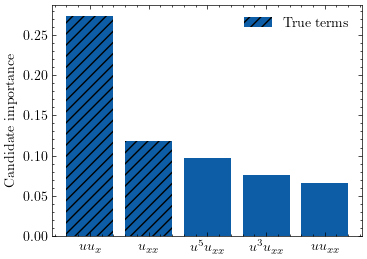

In [16]:
import sympy
def show_polynomial_derivative(p: int, d: int):
    if p < 0 or d < 0:
        raise ValueError("Polynomial degree and derivative order must be non-negative integers.")
    polynomial_part = sympy.Symbol('u') if p == 1 else sympy.Symbol(f"u^{p}") if p > 0 else sympy.Integer(1)    
    derivative_part = f"u_{'x'*d}" if d > 0 else ''
    if len(derivative_part) < 1:
        return sympy.simplify(polynomial_part)
    derivative_part = sympy.Symbol(derivative_part)
    return sympy.simplify(polynomial_part*derivative_part)

shap_candidate_names = ['$'+sympy.latex(show_polynomial_derivative(_[0], _[1]))+'$' for _ in shap_candidates]

with plt.style.context(['science']):
    fig, ax = plt.subplots(figsize=(4, 3))
    bars = ax.bar(shap_candidate_names, [candidate_importance[_] for _ in shap_candidates])
    for i, bar in enumerate(bars):
        if i < 2:
            bar.set_hatch('///')
        else:
            bars[i-1].set_label("True terms")
            break
    ax.set_ylabel("Candidate importance")
    ax.legend()
    # plt.savefig(f"Figures/importance_SMSEMOA_burgers_noise{int(noise_lv)}.pdf")
    plt.show()

### Compromise programming ###

In [17]:
from collections import Counter
from pymcdm.methods import TOPSIS, MABAC, COMET, SPOTIS
from pymcdm import weights as obj_w
from pymcdm.helpers import rrankdata
from pymcdm.methods.comet_tools import MethodExpert
from pymcdm import visuals

F = problem.evaluate(pareto_optimal_models)
nF = (F - F.min(axis=0))/(F.max(axis=0) - F.min(axis=0))

obj_weights = obj_w.entropy_weights(F)
types = [-1, -1]
cvalues = COMET.make_cvalues(F)
expert_function = MethodExpert(TOPSIS(), obj_weights, types)
bounds = SPOTIS.make_bounds(F)

method_names = ['TOPSIS', 'MABAC', 'COMET', 'SPOTIS']
methods = [
    TOPSIS(),
    MABAC(),
    COMET(cvalues, expert_function),
    SPOTIS(bounds)
]

ranks = [method.rank(method(F, obj_weights, types)) for method in methods]
balance_point = F[sorted(Counter(np.argmin(ranks, axis=1)).most_common())[0][0]]
print("Optimal balance:", balance_point)
est_complexities = sorted(set(np.argsort(ranks)[:, 0]))
est_complexities = list(range(0, max(est_complexities)+1))
pareto_optimal_models = pareto_optimal_models[est_complexities]
est_complexities = F[est_complexities][:, 1].astype(np.int32)
min_ss = 1
max_ss = max(est_complexities)

# fig, ax = plt.subplots(figsize=(7, 3), dpi=300, tight_layout=True)
# visuals.ranking_bar(ranks, labels=method_names, ax=ax)
# plt.show()

pareto_optimal_models

Optimal balance: [6.7205343e-06 2.0000000e+00]


array([[frozenset({(0, 1)})],
       [frozenset({(1, 1), (0, 2)})]], dtype=object)

In [18]:
top_candidates = extract_unique_candidates(pareto_optimal_models)
additional_candidates = []
additional_candidates = [(0, 4)]
top_candidates.extend(list(set(additional_candidates)-set(top_candidates)))

X_pre_top = problem.numericalize_genome(top_candidates)
# np.save(os.path.join(R_path, f"X_pre_top_burgers_noise{int(noise_lv)}.npy"), X_pre_top)
X_pre_top = (X_pre_top - X_pre_top.mean(axis=0))/X_pre_top.std(axis=0)

top_candidates

[(0, 1), (0, 2), (1, 1), (0, 4)]

### Using KnockoffFilter to compute X_pre_top instead GA

In [19]:
from abess import LinearRegression as AbessLinearRegression
# from L0learn import L0Learn
# from SCO import SCO
from knockpy import KnockoffFilter, knockoff_stats, knockoffs
from knockpy.utilities import estimate_covariance
from scipy import stats
from statsmodels.stats.multitest import multipletests
from c2st.check import c2st # https://github.com/psteinb/c2st

u_pre = y_pre.copy()
X_pre_top = StandardScaler().fit_transform(X_pre)
y_pre = StandardScaler().fit_transform(u_pre)

# lr = SCO(path_type='gs', sparsity=10, ic_method='LinearSIC')
lr = AbessLinearRegression(path_type='gs', s_max=10, fit_intercept=False, cv=5, screening_size=0)

### GOODS: ShapStatistic, PIStatistic, Eli5PIStatistic, AlibiPDStatistic ###
# fstat = knockoff_stats.Eli5PIStatistic(model=lr, n_iter=10)
# fstat = knockoff_stats.AlibiPDStatistic(model=lr)
# fstat = knockoff_stats.AlibiPIStatistic(model=lr, n_repeats=30) # slow
# fstat = knockoff_stats.PIMPStatistic(model=lr, feature_names=feature_names)
# fstat = knockoff_stats.PIStatistic(model=lr)
fstat = knockoff_stats.ShapStatistic(model=lr)

kfilter = KnockoffFilter(ksampler='gaussian', fstat=fstat, knockoff_kwargs={'method':'ci'})
# kfilter = KnockoffFilter(ksampler='gaussian', fstat='lasso', knockoff_kwargs={'method':'ci'})

fdr = 0.2
rejections = []
for _ in trange(50):
    rejection = kfilter.forward(X=X_pre_top, y=y_pre.flatten(), fdr=fdr, shrinkage="ledoitwolf", recycle_up_to=0.5, tol=1e-3)
    rejection = set(np.where(rejection == 1)[0])
    if len(rejection) > 0:
        rejections.append(rejection)

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:26<00:00,  1.90it/s]


In [20]:
rejections = np.array(sorted(biggest_superset(rejections)))
print(feature_names[rejections])
X_pre_top = X_pre_top[:, rejections]

['x0_11' 'x0_1111' 'x0_11111' 'x0_111111' 'x0x0_1' 'x0^3x0_1' 'x0^4x0_1'
 'x0^5x0_1' 'x0^6x0_111' 'x0^3x0_111111']


In [21]:
alpha = 0.05
classifer_threshold = 0.5
while True:
    non_null_indices, shap_values = shap_model_selection(X_pre_top, y_pre)
    rejections = rejections[non_null_indices]
    X_pre_top = X_pre_top[:, non_null_indices]
    print(abs(shap_values).mean(axis=0))
    print(feature_names[rejections])

    decision = True
    Sigma, invSigma = estimate_covariance(X_pre_top, 1e-3, "graphicallasso")
    for j in range(len(rejections)-1, -1, -1):
        classifier_confidences = []
        for _ in trange(50):
            Xk = knockoffs.GaussianSampler(X_pre_top, Sigma=Sigma, invSigma=invSigma, 
                                           method='ci').sample_knockoffs()
            Xn = X_pre_top.copy()
            Xn[:, j] = Xk[:, j]
            
            swap_explainer = shap.explainers.Linear(linear_model.LinearRegression(fit_intercept=False).fit(Xn, y_pre),
                                                    Xn)
            swap_shap_values = swap_explainer(Xn).values
            
            classifier_confidences.append(c2st(shap_values[:, j:j+1], swap_shap_values[:, j:j+1], clf=linear_model.LogisticRegression(fit_intercept=True)))
    
        classifier_confidences = np.array(classifier_confidences)
        pv = stats.wilcoxon(classifier_confidences-classifer_threshold, alternative='greater').pvalue
        
        print("binary classifier's acc:", classifier_confidences.mean())
        print("P-value:", pv)
    
        if not pv < alpha:
            decision = False
            break

    if not decision:
        non_null_indices = list(solvel0(X_pre_top, y_pre, max_complexity=len(rejections)-1, miosr=True, refine=True)[-1])
        rejections = rejections[non_null_indices]
        X_pre_top = X_pre_top[:, non_null_indices]
    else:
        break

# Optional
nonzero_miosr = np.array([], dtype=np.int32)
for _ in range(len(rejections)):
    nonzero_miosr = np.union1d(nonzero_miosr, np.nonzero(MIOSR(X_pre, y_pre, len(rejections)-_))[0])
rejections = np.intersect1d(rejections, nonzero_miosr)
feature_names[rejections]

[0.52719122 0.24548322 0.17607604 0.14593078 0.12465901 0.04228806
 0.03130801 0.01284058 0.00929264]
['x0x0_1' 'x0_11' 'x0^3x0_1' 'x0^4x0_1' 'x0_1111' 'x0_111111' 'x0^5x0_1'
 'x0^3x0_111111' 'x0^6x0_111']


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:24<00:00,  2.02it/s]


binary classifier's acc: 0.4715455637678949
P-value: 0.9999998580419627


  0%|                                                                                                  | 0/8 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2026-04-04


100%|██████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 32.64it/s]


[0.49817293 0.24629396 0.12380259 0.10606321 0.07256374 0.04084804
 0.01369496]
['x0x0_1' 'x0_11' 'x0_1111' 'x0^4x0_1' 'x0^5x0_1' 'x0_111111'
 'x0^3x0_111111']


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.97it/s]


binary classifier's acc: 0.4805334278716664
P-value: 0.9875761622740677


100%|██████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 27.08it/s]


[0.47699599 0.23647392 0.11379032 0.03706292 0.02122138]
['x0x0_1' 'x0_11' 'x0_1111' 'x0_111111' 'x0^4x0_1']


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:17<00:00,  2.93it/s]


binary classifier's acc: 0.5940747399153835
P-value: 8.881784197001252e-16


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.03it/s]


binary classifier's acc: 0.5132178204870543
P-value: 3.777610438190336e-10


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.32it/s]


binary classifier's acc: 0.5495699295002017
P-value: 3.7741950137940186e-10


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.23it/s]


binary classifier's acc: 0.6255926785203477
P-value: 8.881784197001252e-16


100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:15<00:00,  3.15it/s]


binary classifier's acc: 0.8515200460721039
P-value: 3.771635265926408e-10


array(['x0_11', 'x0_1111', 'x0x0_1'], dtype='<U13')

### Best-subset selection

In [22]:
X_pre_top = X_pre[:, rejections]
X_pre_top = X_pre_top/np.linalg.norm(X_pre_top, 2, axis=0)
y_pre = u_pre.copy()
# y_pre = y_pre/np.linalg.norm(y_pre, 2, axis=0)

In [23]:
from mbic import mbic, mbic2, ebic
best_subsets = solvel0(X_pre_top, y_pre, miosr=True, refine=True)
best_subsets = [tuple(best_subsets[-1][_] for _ in bs) 
                for bs in brute_force_all_subsets(X_pre_top[:, best_subsets[-1]], y_pre)[1]]
for _ in best_subsets:
    loglik = log_like_value(X_pre_top[:, _]@np.linalg.lstsq(X_pre_top[:, _], y_pre, rcond=None)[0], 
                            y_pre)
    print("EBIC:", ebic(loglik, len(_), len(y_pre), X_pre_top.shape[-1], const=0), end=' | ')
    print("MBIC:", mbic(loglik, len(_), len(y_pre), X_pre_top.shape[-1], const=2))
    print()

100%|█████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 428.57it/s]

EBIC: -79844.48222575583 | MBIC: -79848.06574469428

EBIC: -90704.04040656597 | MBIC: -90709.01021986554

EBIC: -92102.48685793696 | MBIC: -92106.64574102033



### Model selection using UBIC

In [24]:
# TODO: Calculate post_means for ARDRegression as well (Implement the ard_uncertainties function)
ard_uns = []
threshold_lambda = 5e5 # must pass assert 
for bs in best_subsets:
    ard = linear_model.ARDRegression(fit_intercept=False, 
                                     compute_score=True,
                                     threshold_lambda=threshold_lambda)
    ard.fit(X_pre_top[:, bs], y_pre.ravel())
    assert len(bs) == len(np.nonzero(ard.coef_)[0])
    # Robust data-driven discovery of governing physical laws with error bars (error_bar not enough to identify the governing PDE...)
    error_bar = sum(np.diag(ard.sigma_)/ard.coef_**2); print(error_bar)
    pde_uncert = np.sqrt(np.diag(ard.sigma_)).sum()/abs(ard.coef_).sum()
    ard_uns.append(pde_uncert)
ard_uns = np.array(ard_uns)
ard_uns = ard_uns/min(ard_uns)
ard_uns

3.215847781967292e-05
6.027673843736649e-05
0.0007192256699423298


array([1.32363577, 1.        , 1.3937139 ])

In [25]:
tau = 3
verbose = True
# scale = 1 <- generalized UBIC
scale = np.log(len(y_pre))
per = 75 # 80

post_means, b_bics, b_uns = baye_uncertainties(best_subsets, (X_pre_top, y_pre), 
                                               u_type='cv1', take_sqrt=True, 
                                               ridge_lambda=0, 
                                               threshold=0)
# b_uns = ard_uns # USE ard_uns INSTEAD
predictions = X_pre_top@post_means
print(b_bics)
print(b_uns)
b_bics = np.array(b_bics)
max_complexity = len(b_bics)
complexities = np.arange(max_complexity)+1
d_complexities = complexities[decreasing_values_indices(b_bics)]
d_bics = b_bics[decreasing_values_indices(b_bics)]
slopes = np.diff(b_bics)/(np.diff(complexities)*b_bics[:-1])
try:
    thres = np.percentile(np.abs(np.diff(d_bics)/(np.diff(d_complexities)*d_bics[:-1])), per)
    thres = math.ceil(sci_format(thres)[0])*10**sci_format(thres)[1]
except IndexError:
    thres = 1/40
min_thres = 1/40
thres = max(thres, min_thres)
print("threshold:", thres)

lower_bounds = []
for k, efi in enumerate(best_subsets):
    # assert len(efi) == np.count_nonzero(post_means[:, k:k+1])
    com = len(efi)
    lower_bound = 2*np.abs(log_like_value(predictions[:, k:k+1], y_pre))-np.log(len(y_pre))*com
    lower_bounds.append(lower_bound)

last_lam = np.log10(max(lower_bounds/(b_uns*scale)))
print("max_lam:", last_lam)
delta = last_lam/tau
now_lam = last_lam-delta
last_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**last_lam, scale=scale)
last_bc = np.argmin(last_ubic)
bc_seq = [last_bc]
while now_lam >= 0:
    now_ubic = UBIC(b_bics, b_uns, len(y_pre), hyp=10**now_lam, scale=scale)
    now_bc = np.argmin(now_ubic)
    
    diff_com = now_bc-last_bc
    diff_bic = b_bics[now_bc]-b_bics[last_bc]
    imp = np.nan
    if diff_com != 0:
        imp = abs(diff_bic/(b_bics[last_bc]*diff_com))
    
    if verbose:
        print(min(last_bc, now_bc), '<--->', max(last_bc, now_bc), 
              np.nan_to_num(imp, nan=np.inf))
    
    if (diff_com > 0 and (diff_bic > 0 or imp < thres)) or \
        (diff_com < 0 and diff_bic > 0 and imp > thres):
        break
    
    last_lam = now_lam
    now_lam = round(last_lam-delta, 8)
    last_ubic = now_ubic
    last_bc = now_bc
    if last_bc not in bc_seq:
        bc_seq.append(last_bc)

# best_bc = knee(range(len(last_ubic)), last_ubic, 0.95, 'linear', direction='decreasing')
best_bc = knee_finder(last_ubic)
if best_bc == 0 and last_bc != 0 and b_bics[last_bc] < b_bics[0] and \
                                    abs((b_bics[last_bc]-b_bics[0])/(b_bics[0]*last_bc)) > thres:
    best_bc = knee(range(1, len(last_ubic)), last_ubic[1:], 0.95, 'linear')
if best_bc is None:
    best_bc = knee_finder(last_ubic)
    
last_lam = round(last_lam, 8)
last_lam, last_ubic, last_bc, best_bc

[-79846.67945033316, -90706.2376311433, -92102.48685793696]
[1.32369969 1.         1.39372585]
threshold: 0.2
max_lam: 3.9933614733572473
1 <---> 1 inf
1 <---> 2 0.015393089419842387


(2.66224098, array([-74245.15639325, -86474.52018182, -86204.63284542]), 1, 1)

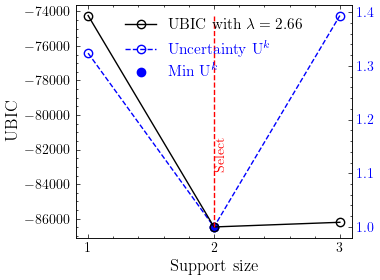

In [26]:
complexity_axis = [len(bs) for bs in best_subsets]
with plt.style.context(['science']):
    fig, ax = plt.subplots(figsize=(4, 3))
    ax2 = ax.twinx()
    ax.set_zorder(ax2.get_zorder()+1)
    ax.patch.set_visible(False)
    
    l1, = ax.plot(complexity_axis, last_ubic, 'o-', c='black', markerfacecolor='none', label=f"$\lambda = {abs(last_lam)}$")
    ax.set_xticks(complexity_axis)
    ax.set_ylabel("$\\textrm{UBIC}$", fontsize=12)
    ax.set_xlabel("Support size", fontsize=12)
    ax.vlines(best_bc+1, min(last_ubic), max(last_ubic), linestyles='--', color='red')
    ax.text(best_bc+1, np.mean(last_ubic), 'Select', color='red', rotation=90, verticalalignment='center')
    l2, = ax2.plot(complexity_axis, b_uns, 'o--', c='blue', markerfacecolor='none', label="Uncertainty $\\textrm{U}^{k}$")
    s1 = ax2.scatter(complexity_axis[np.argmin(b_uns)], b_uns[np.argmin(b_uns)], c='blue')
    ax2.tick_params(axis='y', labelcolor='blue')
    ax.legend([l1, l2, s1], [f"UBIC with $\lambda = {round(abs(last_lam), 2)}$", "Uncertainty $\\textrm{U}^{k}$", "Min $\\textrm{U}^{k}$"], 
              labelcolor='linecolor', loc='upper center', fontsize=11)
    plt.tight_layout()
    # plt.savefig(f"Figures/ubic_burgers_noise{int(noise_lv)}.pdf")
    # plt.savefig(f"Figures/ubic_SMSEMOA_burgers_noise{int(noise_lv)}.pdf")
    # plt.savefig(f"Figures/ubic{len(last_ubic)}_SMSEMOA_burgers_noise{int(noise_lv)}.pdf")
    plt.show()

### Selective inference

In [27]:
from selective_inference import sfs_si, stepwise_selective_inference, subset_fdr
import fpsample
from dppy.finite_dpps import FiniteDPP

In [28]:
n_samples = 200
test_subset = [13, 8, 10]
si_result = None
for _ in range(10):
    np.random.seed(random.randint(0, 100))
    sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
    si_result = sfs_si(1, 
                       StandardScaler().fit_transform(X_pre[:, test_subset])[sample_indices], 
                       y_pre.ravel()[sample_indices], 
                       3, sigma=np.std(y_pre))
    if si_result is not None:
        break
    
print("SFS")
si_result

SFS


SI_result(A=[0, 1, 2], k=3, sigma=0.009048904820791643, p_values=[0.1076871943915519, 0.475296405641106, 0.802458921871819], CIs=[[-0.018959563307623897,0.0018663316213143031], [-0.008979786575036307,0.0192689867560394], [-0.011320701876978726,0.014633439013456423]])

In [29]:
from si4pipeline import (
                        construct_pipelines, 
                        extract_features, 
                        initialize_dataset, 
                        intersection, 
                        lasso, 
                        marginal_screening, 
                        stepwise_feature_selection, 
                        union, 
                        PipelineManager
                        )

In [30]:
np.random.seed(0); random.seed(0)
n_samples = 250*(best_bc+1)
# max_fdr = 0.2; false_discovery_control_method = 'by'
max_fdr = 0.2; false_discovery_control_method = 'bh'
# max_fdr = 0.2; false_discovery_control_method =  None
for bs in best_subsets:
    fdrs = []
    for _ in range(len(y_pre)//n_samples):
        X_test = X_pre_top[:, bs]
        y_test = y_pre.ravel()
        
        np.random.seed(random.randint(0, 100))
        # sample_indices = sorted(set([np.random.randint(len(y_pre)) for _ in range(n_samples)]))
        # with > 8 candidate terms, use fps_npdu_sampling
        sample_indices = fpsample.bucket_fps_kdline_sampling(X_test, n_samples=n_samples, h=3) # Farthest Point Sampling (FPS) is better!!!
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        # FPS + k-DPP
        DPP = FiniteDPP('likelihood', **{'L': X_test.dot(X_test.T)})
        DPP.flush_samples()
        for _ in range(n_samples//(len(bs))):
            DPP.sample_exact_k_dpp(size=len(bs))
        sample_indices = np.unique(np.ravel(DPP.list_of_samples))
        X_test = X_test[sample_indices]; y_test = y_test[sample_indices]
        
        manager = stepwise_selective_inference(support_size=X_test.shape[1])
        M, p_list = manager.inference(X_test, y_test, np.std(y_test))
        if false_discovery_control_method is not None:
            p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
        # print(M, p_list, np.array(p_list) < 0.05)
        fdrs.append(subset_fdr(p_list))
        
    fdrs = np.array(fdrs)
    print(fdrs.mean(), stats.wilcoxon(fdrs-max_fdr, alternative='less').pvalue)

0.0 3.872108215522035e-06
6.044026390500346e-13 4.422457510605951e-05
0.05561844438550482 4.422457510605951e-05


In [31]:
np.random.seed(0); random.seed(0)
# max_fdr = 0.2; false_discovery_control_method = 'by'
max_fdr = 0.2; false_discovery_control_method = 'bh'
# max_fdr = 0.2; false_discovery_control_method =  None
for bs in best_subsets:
    X_test = X_pre_top[:, bs]
    y_test = y_pre.ravel()
    
    manager = stepwise_selective_inference(support_size=X_test.shape[1])
    M, p_list = manager.inference(X_test, y_test, np.std(y_test))
    if false_discovery_control_method is not None:
        p_list = stats.false_discovery_control(p_list, method=false_discovery_control_method)
    fdr = subset_fdr(p_list)
    
    print(fdr)

0.0
0.0
0.0


### Intercept or NO Intercept? ###

In [32]:
true_indices = [8, 13]
true_coefficients = [0.1, -1]
true_ols = sm.OLS(y_pre, X_pre[:, true_indices]).fit()
estimated_coefficients = true_ols.params
print(estimated_coefficients, mean_absolute_percentage_error(true_coefficients, estimated_coefficients))
true_ols.bic, sm.OLS(y_pre, X_pre[:, [0] + true_indices]).fit().bic

[ 0.09297372 -0.97441361] 0.04792457098546819


(-90706.2376311433, -90697.14117538782)

### Visualization ###

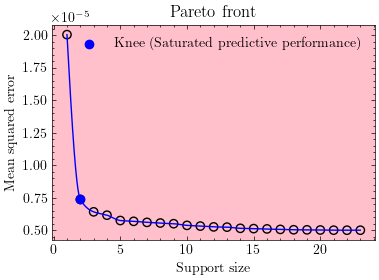

In [26]:
from scipy.interpolate import CubicSpline, PchipInterpolator
pareto_front = np.load(add_prefix(pf_file_path, 'refined_'), allow_pickle=True)
pareto_front = problem.evaluate(pareto_front)
pareto_front = pareto_front[np.argsort(pareto_front[:, 1])]
spline = PchipInterpolator(pareto_front[:, 1], pareto_front[:, 0])
x_plot = np.linspace(pareto_front[:, 1].min(), pareto_front[:, 1].max(), len(pareto_front[:, 1])*100)

bg_color = 'pink'
with plt.style.context(['science']):
    plt.rcParams['axes.facecolor'] = bg_color
    plt.figure(figsize=(4, 3))
    plt.plot(x_plot, spline(x_plot), color='blue')
    plt.scatter(pareto_front[:, 1], pareto_front[:, 0], facecolor='None', edgecolors='black')
    plt.scatter(max_ss, pareto_front[:, 0][max_ss-1], color='blue', label='Knee (Saturated predictive performance)')
    plt.ylabel("Mean squared error")
    plt.xlabel("Support size")
    plt.title("Pareto front")
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"Figures/pf_burgers_noise{int(noise_lv)}.pdf")
    # plt.savefig(f"Figures/pf_SMSEMOA_burgers_noise{int(noise_lv)}.pdf")
    plt.show()

In [27]:
pool.close()

### Bayesian model evidence ###

In [28]:
v = 1e-2
while 1:
    bme = [log_evidence(X_pre_top, y_pre, effective_indices=bs, v=v) for bs in best_subsets]
    if np.argmax(bme) >= knee_finder(b_bics): break
    else: v *= 10
bme_knee = knee(range(len(bme)), bme, 0.95, 'linear', direction='increasing')
bme, np.argmax(bme), bme_knee

([-7609.75681286884, -3126.1403810019497], 1, 1)

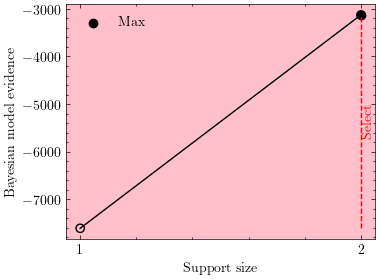

In [29]:
with plt.style.context(['science']):
    plt.rcParams['axes.facecolor'] = 'pink'
    plt.figure(figsize=(4, 3))
    plt.plot(range(1, len(bme)+1), bme, color='black')
    plt.scatter(range(1, len(bme)+1), bme, facecolor='None', edgecolors='black')
    plt.scatter(np.argmax(bme)+1, bme[np.argmax(bme)], label='Max', color='black')
    plt.vlines(bme_knee+1, min(bme), max(bme), linestyles='--', color='red')
    plt.xlabel("Support size")
    plt.ylabel("Bayesian model evidence")
    plt.xticks(range(1, len(bme)+1))
    plt.text(bme_knee+1, np.mean(bme), 'Select', color='red', rotation=90, verticalalignment='center')
    plt.legend()
    plt.tight_layout()
    # plt.savefig(f"Figures/bme_burgers_noise{int(noise_lv)}.pdf")
    # plt.savefig(f"Figures/bme_SMSEMOA_burgers_noise{int(noise_lv)}.pdf")
    # plt.savefig(f"Figures/bme{len(bme)}_SMSEMOA_burgers_noise{int(noise_lv)}.pdf")
    plt.show()

In [30]:
brute_force_all_subsets(X_pre, y_pre, max_support_size=2)

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.65it/s]


(array([[   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,  -37.10128211,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
         